# Section 2: Numerically Solving the TDSE

Last week, we developed code to solve the time-independent Schrodinger equation (TISE). In that code, we used a second-order finite difference approximation to the second derivative and then computed numerical eigenvalues and eigenvectors associated with the Hamiltonian. In this week's section, we'll take a similar approach to solve the time-*dependent* Schrodinger equation (TDSE). After developing the numerical method and writing code to implement it, we will propagate Gaussian wavepackets to look at their behavior in free space and as they interact with some interesting potentials.

**Learning Goals:**
After this Section you should be able to: 

- Understand how to discretize the Schrodinger equation in both space and time
- Explain the difference between the Crank-Nicolson method and the forward- or backward-difference methods
- Compute and describe the behavior of a Gaussian wavepacket moving in free space
- Simulate and qualitatively rationalize the behavior of a Gaussian wavepacket interacting with at least one potential

## Background: Simulating Time Dependence

In class, we talked about one way to think about how an arbitrary wavefunction evolves in time that relies on the simple time evolution of energy eigenstates. That idea was as follows:

- Express an arbitrary wavefunction $\phi(x)$ as a superposition of the energy eigenstates for the specific potential of interest. This gives you an expression like $\phi(x) = \sum_{n} c_n \psi_n(x)$, where the $c_n$ can be determined (either numerically or analytically) by taking inner products between the state $\phi(x)$ and the energy eigenstates.
- Append the appropriate time-dependent phase factor to each term in this series, yielding $\phi(x,t) = \sum_{n} c_n \psi_n(x) e^{-i \omega_n t}$.
- Evaluate the sum at each time $t$ of interest.

You'll get more practice with this idea on future homeworks and in future Sections, but today we are going to talk about a different way to find time-dependent solutions to the Schrodinger equation---specifically, we'll try to integrate the Schrodinger equation *directly* without relying on a prior determination of the energy eigenstates. We are doing this so you can get more exposure to numerical solutions of differential equations and learn some intuition about how free particles move through different potentials. 

The specific method we will use is called the Crank-Nicolson method. It is probably one of the simplest possible ways to solve the TDSE; it is not particularly efficient, but it is good enough for our purposes right now.

## Deriving the Crank-Nicolson Method

Recall from class that the TDSE is given by 

$$
i \hbar \frac{\partial \Psi}{\partial t} = -\frac{\hbar^2}{2m} \frac{\partial^2 \Psi}{\partial^2 x} + V(x) \Psi.
$$ {#eq-TISE}

The right-hand side is exactly the same as the Hamiltonian terms involved in the TISE, but now we also need to handle the temporal derivative. 

Let's use $j$ as a subscript index to discretize space, with step size $\Delta x$, and $n$ as a superscript index to discretize time, with step size $\Delta t$.

**Question for the class: How should we fill in the following equations?** 
$$
\frac{\partial^2 \Psi}{\partial^2 x} \rightarrow \frac{\Psi_{j+1} - 2 \Psi_{j} + \Psi_{j-1}}{\Delta x^2}
$$ {#eq-SpaceDiscrete}

$$
\frac{\partial \Psi}{\partial t} \rightarrow \frac{\Psi^{n} - \Psi^{n-1}}{\Delta t}
$$ {#eq-TimeDiscrete}

Once we have the discretization formulas, we can plug these back into @eq-TISE. But here's a question: *at which time index do we evaluate the right-hand side?*

### Forward-Difference Approximation
The obvious choise might be to use time $n-1$ on the RHS, since then we have an equation that gives $\Psi_{j}^{n}$ in terms of $\Psi_{j-1}^{n-1}$, $\Psi_{j}^{n-1}$, and $\Psi_{j+1}^{n-1}$. However, this has a problem! It introduces errors that can grow exponentially in time. That is NOT good.

**Question for the class: Can you see how you might convince yourself this is true?**

### Backward-Difference Approximation
Ok, so we can't use the simplest solution and still obtain a stable method. What if we express $\Psi_{j}^{n}$ in terms of $\Psi^{n+1}?$ That's a little funny because now the equation relates $\Psi_{j}^{n}$ to a bunch of values that haven't been determined yet! It's actually not a huge deal because we can in principle solve a system of (linear) equations to obtain the wavefunctions. But this method actually doesn't conserve probability. That is also NOT good.

**Question for the class: Can you see how to convince yourself about the issues with the backward-difference method? (This one is harder at this stage in the course... but (if this makes sense to you from your previous QM knowledge) you should think about the idea of unitary evolution.**

## Crank-Nicolson Method
It turns out, we can play a clever trick developed by John Crank and Phyllis Nicolson. We can *average* the forward- and backward-difference approximations together. It turns out this solves the problems associated with stability and probability conservation, and it's pretty easy to code. In component form, this looks like:

$$
i \hbar \frac{\Psi_{j}^{n} - \Psi_{j}^{n-1}}{\Delta t} = -\frac{\hbar^2}{2m} \frac{(\Psi_{j+1}^{n} - 2 \Psi_{j}^{n} + \Psi_{j-1}^{n}) + (\Psi_{j+1}^{n-1} - 2 \Psi_{j}^{n-1} + \Psi_{j-1}^{n-1})}{2 \Delta x^2} + V_j \frac{\Psi_{j}^{n} + \Psi_{j}^{n-1}}{2}.
$$ {#eq-CNTISE}

If we sort the terms by their time index (index $n$ on the LHS and index $n-1$ on the RHS), we get:
$$
(1+ i \Delta t H/2\hbar) \Psi^{n} = (1-i \Delta t H/2\hbar) \Psi^{n-1}
$$ {#eq-SortedTISE}

This is great. It means that if we build a matrix representation of the Hamiltonian (which we already know how to do!) we can propagate the wavefunction in time by multiplying by
$$
C = (1+i \Delta t H/2 \hbar)^{-1} (1-i \Delta t H/2\hbar),
$$ {#eq-CNMatrix}
where $C$ is the Crank-Nicolson matrix that advances by one time step:
$$
\Psi^{n} = C \Psi^{n-1}.
$$ {#eq-CNPropagation}
So long as $H$ itself doesn't depend on time, we only need to compute the matrix $C$ once, which makes the algorithm more efficient.

## Task 1: Write functions to propagate a Gaussian wavepacket

Now let's get to the code. First of all, here are the numerical libraries that will be most useful for you today. If you want to add more, just import them in the box below.

In [1]:
# Import the typical numerical and plotting libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

Get started by writing a function `make_gaussian` that creates a Gaussian wavepacket. We wrote the function signature for you, but you'll have to write the body. Make sure that it outputs a vector containing the amplitude of the Gaussian wavepacket at each point in your x grid.

In [12]:
def make_gaussian(x, x0, sigmax, k0):
    Norm_psi = 1/np.sqrt(sigmax*np.sqrt(2*np.pi))
    psi = Norm_psi * np.exp(1j*k0*x) * np.exp(-(x-x0)**2/(2*sigmax)**2)
    return psi

Make sure your code works by generating and plotting a Gaussian wavepacket.

Text(0, 0.5, 'Norm-Squared')

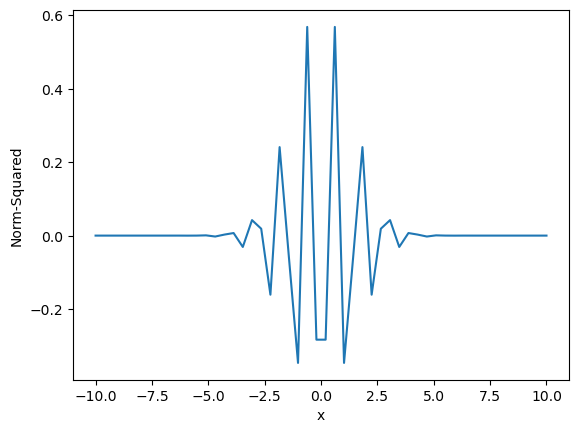

In [17]:
%matplotlib inline
xtest = np.linspace(-10,10)
test_gaussian = make_gaussian(xtest, 0, 1,10)
plt.plot(xtest, test_gaussian)
plt.xlabel('x')
plt.ylabel('Norm-Squared')

Now write the functions to make your Gaussian wavepacket move. In the block below, fill in the functions `make_H` to build the Hamiltonian and return it as a matrix `H` and `make_C` to make the Crank-Nicolson propagation matrix as a matrix `CN`. We need to use @eq-CNMatrix and @eq-CNPropagation to do this.

In [23]:
# Function to make the Hamiltonian given V (in vector form)
def make_H(V):
    N = np.size(V)
    y = -hbar**2/(2*m*dx**2) # helper variable
    H = np.zeros((N,N))
    d0 = np.ones(N) * (-2*y + V) # this is the main diagonal
    d1 = np.ones(N-1) * (y) # This is the +1/-1 diagonal
    H = np.diag(d0) + np.diag(d1, 1) + np.diag(d1, -1) # put it together
    H[0,N-1] = 0 # I'll use periodic boundary conditions but it shouldn't really matter... 
    H[N-1,0] = 0
    return H

# Turn the Hamiltonian into the Crank-Nicolson matrix.
def make_C(V):
    H = make_H(V)
    N = H.shape[1] # Get Hamiltonian dimensions
    z = 0.5*1j*dt/hbar
    CN = np.linalg.inv(np.eye(N) + z*H) @ (np.eye(N) - z*H)
    return CN

The last thing to do before running simulations is to implement the time-stepping. Complete the function `simulate` which, using your other functions, builds a normalized Gaussian wavepacket and propagates it in time. You want this function to return a list of the wavefunctions computed at each time step. 
(Notice how in the function signature we have used *default values*, which is a useful trick you can use in your own code when there are certain values that you might not want to keep resetting over and over...)

In [19]:
# Function to run the simulation
def simulate(V, psi0, max_t_step = 350):
    psi=psi0
    # Make the C-N matrices
    CNmat = make_C(V)

    # run simulation
    tlist = dt * np.arange(max_t_step)
    psi_list = np.zeros((tlist.shape[0], psi.shape[0]), dtype=complex)
    for i in range(tlist.shape[0]):
        psi = CNmat @ psi
        psi_list[i,:] = psi  
        
    return psi_list


Before moving on, let's run a simple test of your code to make sure things seem to work. We'll do this by simulating the motion of a *free particle*. Do this by running your simulate code on the potential energy function $V(x) = 0$ and watching your particle propagate in space. Is the behavior qualitative correct?

First of all, set up your simulation. We are going to work in a "natural" set of units that are defined for you already below. 

In [20]:
# Parameters set for you.
hbar = 1 # hbar is 1 here.
m = 0.5 # electron mass

# These are parameters you can play with to adjust the simulation
x0 = -60 # initial position
k0 = np.pi/10 * 2 # Initial average wavenumber NOTE: Max k value is 2*pi/(2*dx)
sigmak = 1/12 * 1/4 # Initial width in k-space
simWidth = 1600 # Width of simulation
dt = 1 # Time step
dx = 1 # Grid step

# ... and these parameters are fixed by the values you set above.
N = simWidth + 1        # Number of grid points
sigmax = 1/(2*sigmak)   # Initial width in position space
windowWidth = simWidth*dx  # Plot window size
dp = 2*np.pi*hbar/(N*dx)   # k-space width of grid point
E0 = hbar**2*k0**2/(2*m)  # Average energy of initial wave packet
velocity0 = np.sqrt(2*E0/m)   # Average velocity of initial wave packet

You should define a position-space grid with $x$ values ranging from $x_0$ to $x_N$. Make sure to center your well at $x=0$ in the sense that it extends from `-simWidth/2` to `simWidth/2`. Do that here:

In [21]:
x = dx * (np.arange(0,N-1) - simWidth/2)

Now, make a Gaussian wavefunction evolving in free space ($V=0$ everywhere) and with no initial momentum. Plot it and watch it evolve in time from $t=0$ to $t=300$ (in our dimensionless units). What does the wavefunction do?

(-200.0, 200.0)

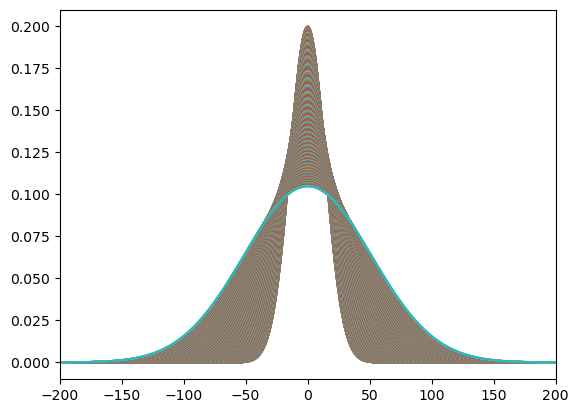

In [22]:
test_gaussian = make_gaussian(x, 0, 10, 0.0)
Vs = np.zeros(test_gaussian.shape)
psi_out = simulate(Vs, test_gaussian)

%matplotlib inline
for i in range(psi_out.shape[0]):
    plt.plot(x, np.abs(psi_out[i,:]))
plt.xlim(-200,200)



Repeat the question above, but now give the Gaussian wavepacket an initial momentum to the right by setting $k_0 \neq 0$. Now how does the wavefunction evolve?

(-300.0, 300.0)

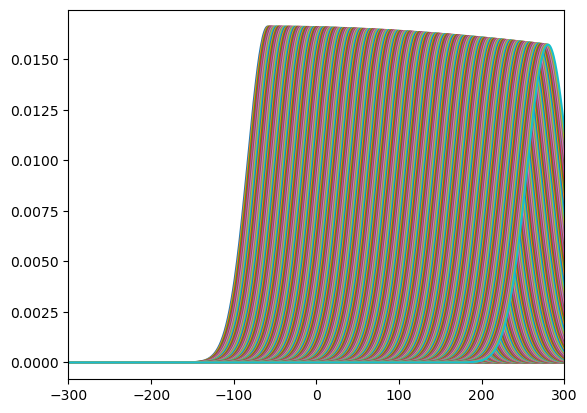

In [9]:
test_gaussian = make_gaussian(x,x0,sigmax,k0)
Vs = np.zeros(test_gaussian.shape)
psi_out = simulate(0*Vs, test_gaussian, 300)

for i in range(300):
    plt.plot(x, np.abs(psi_out[i,:])**2)
plt.xlim(-300,300)


## An aside on animations

Animating your plots in Python takes a little bit of work, so we have written a little function for you that generates an animation that can be plotted inside the Jupyter notebook. You can use this function by feeding it a list of wavefunctions and (optionally) plot limits. The function will automatically plot the *probability density* associated with your wavefunction list. (You'll need to modify it if you want to see the wavefunction directly...)

In [10]:
def make_animation(psi_list, xmin=-100, xmax=100, ymin=0, ymax=0.05, frame_interval=5):
    %matplotlib notebook
    fig, ax = plt.subplots()
    line, = ax.plot([])     # A tuple unpacking to unpack the only plot
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)

    def animate(frame_num):
        y = np.abs(psi_list[frame_num,:])**2
        line.set_data((x, y))
        return line

    anim = FuncAnimation(fig, animate, frames=np.shape(psi_list)[0], interval=frame_interval)
    return anim

As an example of how to use this, let's plot the free particle moving through space:

<IPython.core.display.Javascript object>


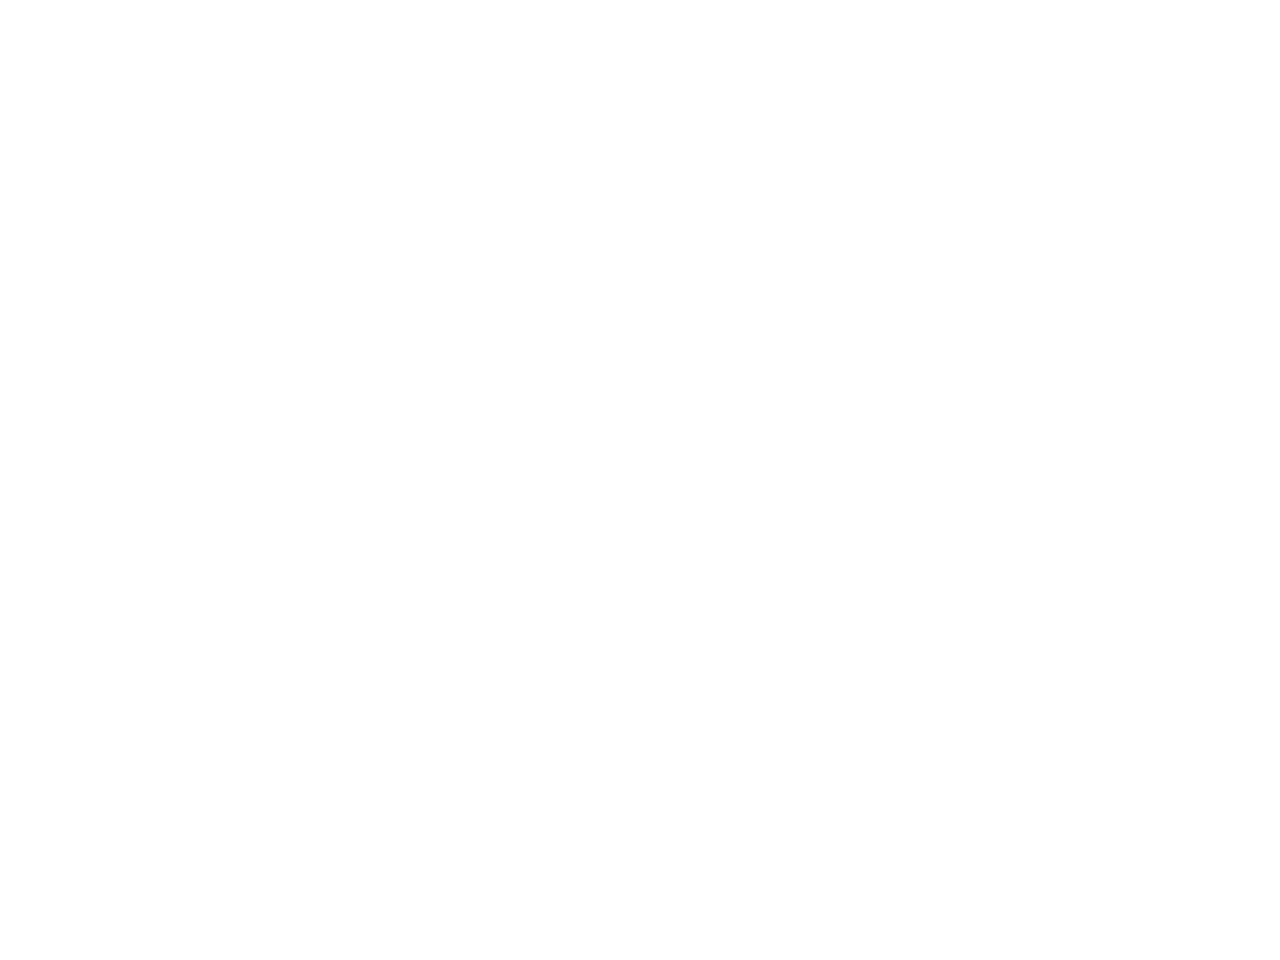

In [11]:
tempvar = make_animation(psi_out, frame_interval=20)
tempvar
plt.show()

## Task 2: Simulate evolution in a potential

Once it seems like your propagation code is working, let's use it to learn some physics! 

We'll look at some more interesting cases, particles moving in actual potentials. For the rest of this Section, you'll work in groups of 2-3 people and each group will choose one of the examples below. At the end of Section, each group will report back to the rest of the class about what they found.

### Project 1: Simulating a quantum mass on a spring

This section is set up to simulate a Gaussian wavepacket evolving in a harmonic potential, $V(x) = \frac{1}{2} \omega^2 x^2$. In the classical case, we know that this gives rise to simple harmonic motion with $x(t) \sim cos(\omega t + \varphi)$. Here you will write code to see if the same thing happens in the quantum world, or to what extent things differ...

And you'll also need to define a potential $V(x)$ for the particle to evolve in. Define that by filling in the code block below. To pick a reasonable value for $\omega$, remember that the value of $E_0$ is tied to the value of $k_0$ and we can't simulate momenta with values greater than $\sim 2\pi/2\Delta x$. Try to think about what that means for how you should set $\omega$ such that it is compatible with your previously chosen simulation parameters...

In [12]:
# set up potential with default values
def Vfunc(a=15, V0=1.5):
    return 1/2 * 30 * E0*(x/np.max(x))**2

Vs = Vfunc(15,1.5)

In [13]:
plt.plot(x,Vs)

In [14]:
test_gaussian = make_gaussian(x,x0,sigmax,0)
done=simulate(Vs, test_gaussian, 800)

<IPython.core.display.Javascript object>


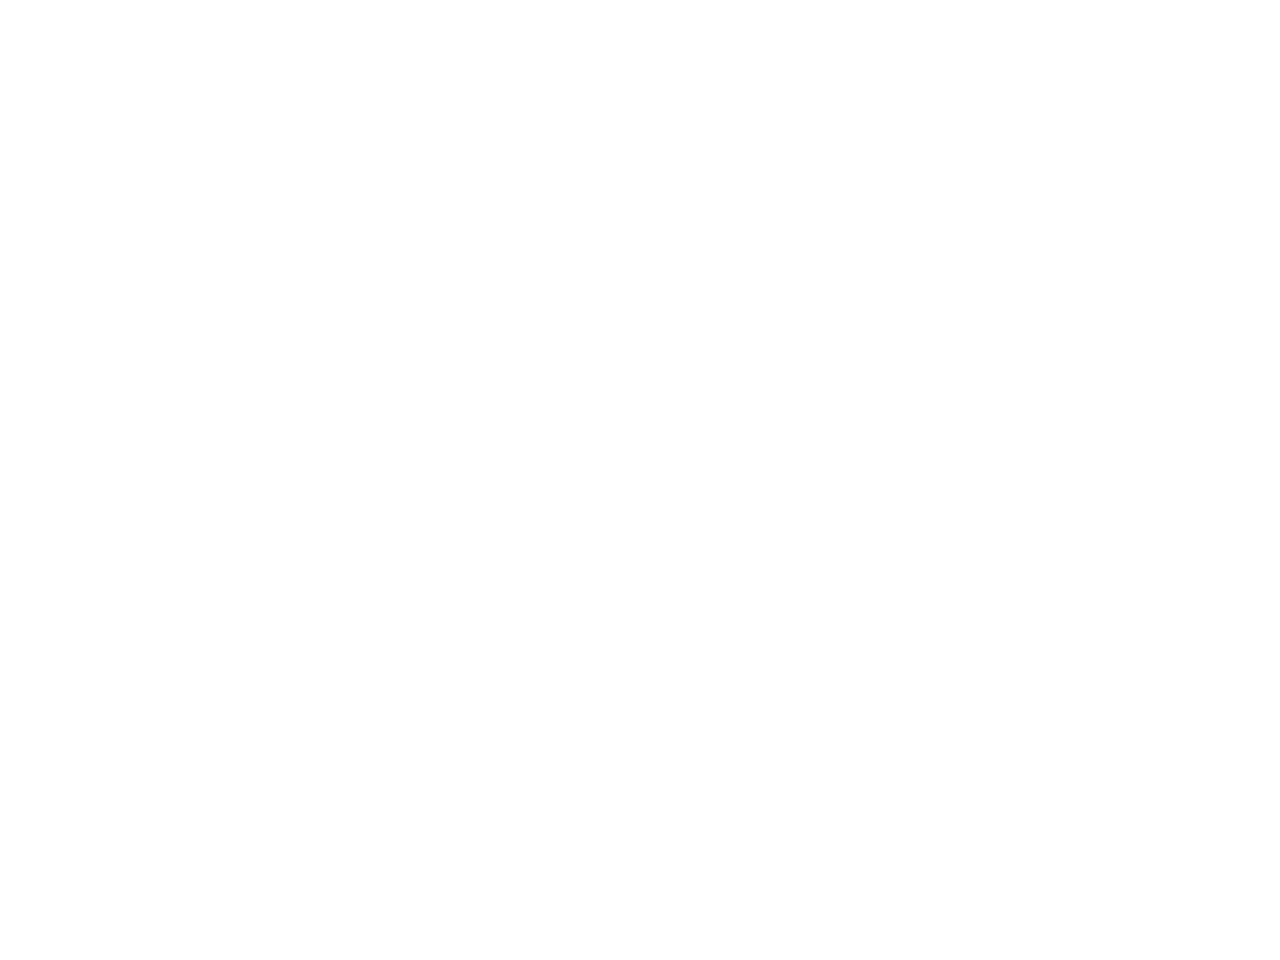

In [15]:
aaa=make_animation(done, xmin=-100, xmax=100, ymin=0, ymax=0.09)
plt.show()

Below, write some code to compute the expectation value of $x$ as a function of time and plot it. Does it evolve like you would expect for a classical particle? If it's different in any way, why do you think it behaves this way?

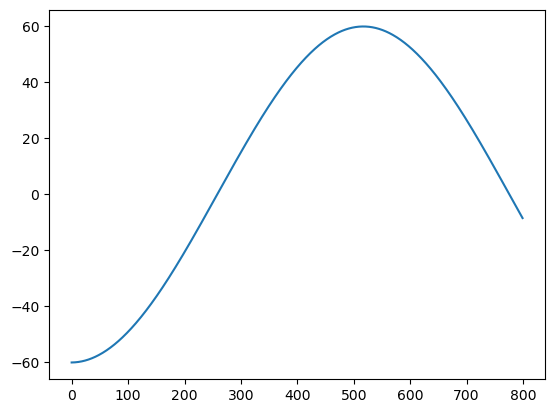

In [16]:
xexp = np.zeros(done.shape[0])
for n in range(done.shape[0]):
    xexp[n] = np.sum(x*np.abs(done[n,:])**2)
    
%matplotlib inline
plt.plot(xexp)

Once you have a feeling for how the particle evolves, try *changing* the potential, for example looking at a quartic ($\propto x^4$) potential. How does the evolution of a particle in this potential differ from that of a harmonic potential? 

### Project 2: Scattering from Square and  Sech-Squared Potential Wells

An unusual aspect of quantum mechanics is that there can be reflection of a particle even from a potential *well*. Here, you will simulate this effect by comparing the scattering of a particle crashing into a square barrier (with positive energy) and a square well (with negative energy). You'll also compare your findings to a particularly interesting potential well, $V(x) \sim - \text{sech}(x)^2$ and uncover an unusual property of this type of well.

First of all, write some code that defines a square well and the sech-squared well. Note that numpy doesn't have the sech function implemented, but it does have a `cosh` function. 

To choose your well depths, pick something that has a width of $\sim 5a - 50a$ and a depth (or height) that is a couple units of $E_0$. Generate vectors `V` below for the different potentials you want to simulate. Plot them with a y-axis normalized by $E_0$ to make sure they are a reasonable scale. (And think about why we need to choose this carefully---hint, think about the simulation parameters we have set.)

In [17]:
# set up potential with default values
def Vfunc(a=15, V0=1):
    return -1.15 * (np.abs(x) < a)

V_sq = Vfunc(8,6)

def Vfunc(a=15, V0=1):
    return -(hbar**2*V0*(V0+1))/(2*m*a**2)*1/np.cosh(x/a)**2

V_sech = Vfunc(5,5.5)

(-100.0, 100.0)

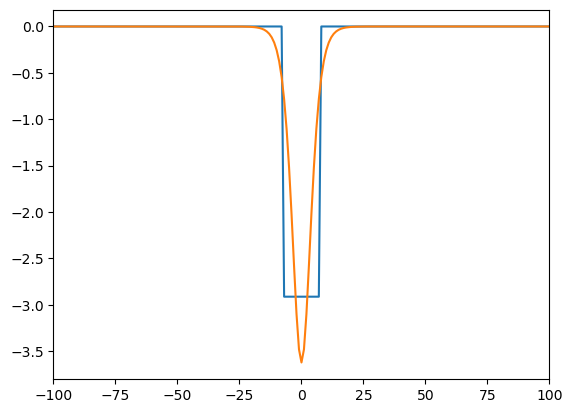

In [18]:
plt.plot(x,V_sq/E0)
plt.plot(x,V_sech/E0)
plt.xlim((-100,100))

Now write code to propagate a Gaussian wavepacket through your different potentials.

In [19]:
test_gaussian = make_gaussian(x,3*x0,sigmax,k0)

def Vfunc(a=15, V0=1):
    return -(hbar**2*V0*(V0+1))/(2*m*a**2)*1/np.cosh(x/a)**2

Vsech = Vfunc(7,8.75)
psi_out_sech = simulate(Vsech, test_gaussian, 800)

def Vfunc(a=15, V0=1):
    return -1.15 * (np.abs(x) < a)

Vsq = Vfunc(5,5)
psi_out_sq = simulate(Vsq, test_gaussian, 800)

Animate your solutions and describe the behavior of a particle that encounters a square well. What happens in this case?


<IPython.core.display.Javascript object>


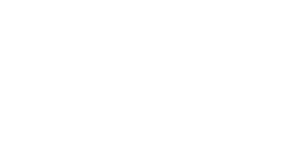

/opt/conda/lib/python3.10/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [20]:
aaa=make_animation(psi_out_sq, xmin=-300, xmax=300, ymin=0, ymax=0.03)
plt.show()

Then, simulate a particle encountering a sech-squared well and describe the differences. What is the major change in this case? Why do you think the behavior is so different? (Hint: An analogy to optics may be useful.) Why might a potential with that sort of behavior be useful?

<IPython.core.display.Javascript object>


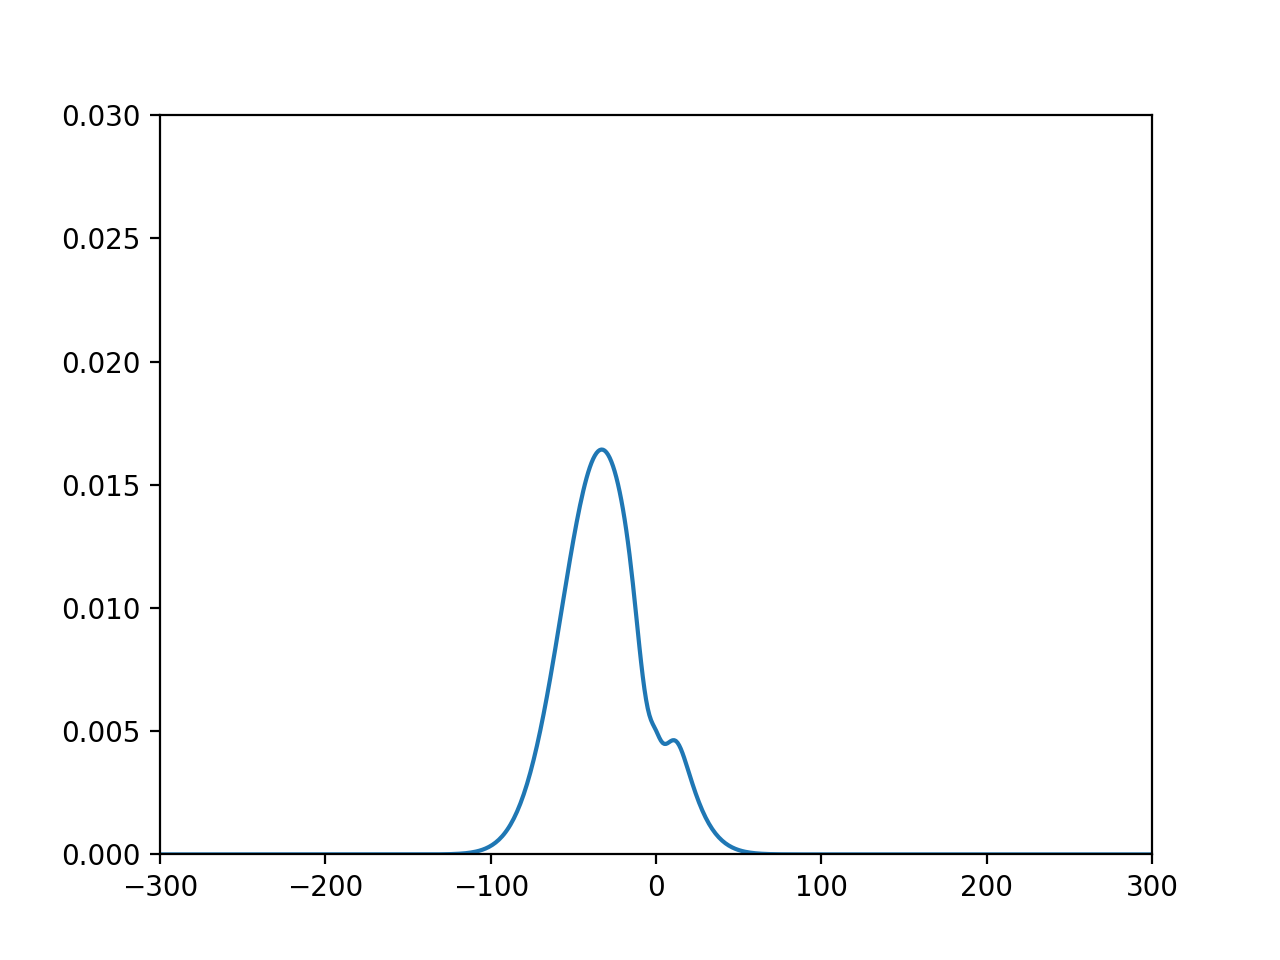

In [21]:
aaa=make_animation(psi_out_sech, xmin=-300, xmax=300, ymin=0, ymax=0.03)
plt.show()

## Conclusion

After completing this Section, you've now learned about numerical solutions of the TDSE, the behavior of a wavepacket in free space, and the behavior of wavepackets evolving in a couple different potentials. You can now use your code to simulate wavepackets interacting with arbitrary potentials! You will use code like what you wrote here to solve problems on HW 2 in which you study the interactions of wavepackets with multi-well potentials as a simple model of particles moving through crystals.